In [1]:
import sys
sys.path.append('../../')

from datetime import date, datetime
r_today = date.today().strftime("%y%m%d")
r_time = datetime.now().strftime("%H%M")
# dataset_seed = int(f'{r_today}{r_time}')
dataset_seed = 2310091953

from keras.callbacks import EarlyStopping

from src.hypermodels import *
from src.utils  import *
from src.dataset import *

question_id = 2

# Load the data

In [2]:
duel_results_path = f'../../data/duel_results/duels_question_{question_id}.csv'
image_file_dir = '../../data/Mapillary_data/Sample_web_green'

print(f'Dataset Seed:{dataset_seed}') # For reproducibility, seed is defined using the date and time (e.g. 2021-01-01 12:30:15 -> seed = 20210101123015)
image_size = 224 
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(duel_results_path, 
                                                                       image_file_dir, 
                                                                       img_size=image_size,
                                                                       model_type='ranking',
                                                                       shuffle=True, 
                                                                       shuffle_seed=dataset_seed)

Dataset Seed:2310091953


Processing Duels: 100%|██████████| 4468/4468 [00:29<00:00, 149.70it/s]


# Data Preprocessing Hyperparameters (Using Keras Preprocessing Layers)

In [3]:
hps_data_preprocessing = {
    'image_preprocessing': {
        'resize': {'height': image_size, 'width': image_size, 'interpolation': 'bicubic'},
        'rescale': {'scale': 1.0 / 255},
    },
    'image_augmentation': {
        'random_rotation': {'factor': 0.4},
        'random_flip': {'mode': 'horizontal_and_vertical'},
        'random_contrast': {'factor': 0.7},
        'random_brightness': {'factor': 0.4, 'value_range': [0.0, 1.0]},
        'random_zoom': {'height_factor': 0.2, 'width_factor': 0.2},
    },
}

image_preprocessing_layers = Sequential(
    [
        layers.Resizing(height=hps_data_preprocessing['image_preprocessing']['resize']['height'],
                     width=hps_data_preprocessing['image_preprocessing']['resize']['width'], 
                     interpolation=hps_data_preprocessing['image_preprocessing']['resize']['interpolation']
                     ),
        layers.Rescaling(scale=hps_data_preprocessing['image_preprocessing']['rescale']['scale'])
    ],
    name='image_preprocessing'
)

image_augmentation_layers = Sequential(
    [
        layers.RandomRotation(factor=hps_data_preprocessing['image_augmentation']['random_rotation']['factor']),
        layers.RandomFlip(mode=hps_data_preprocessing['image_augmentation']['random_flip']['mode']),
        layers.RandomContrast(factor=hps_data_preprocessing['image_augmentation']['random_contrast']['factor']),
        layers.RandomBrightness(factor=hps_data_preprocessing['image_augmentation']['random_brightness']['factor'],
                                value_range=hps_data_preprocessing['image_augmentation']['random_brightness']['value_range']),
        layers.RandomZoom(height_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['height_factor'],
                          width_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['width_factor'])
    ],
    name='image_augmentation'
)

# Model Training Hyperparameters

In [4]:
hps_model_training = {'optimizer': 'adam',
                      'learning_rate': 0.0001,
                      'loss': 'binary_crossentropy',
                      'metrics': ['accuracy'],
                      'batch_size': 64,
                      'epochs': 30,
                      }

# Model Architecture Hyperparameters

In [5]:
hp_model_architecture = {
    'feature_extractor': 'vgg19',
    'num_dense_layers': 2,
    'dense_units': [64,32],
    'dense_dropout_rates': [0.5, 0.5],
    'dense_activation': ['relu', 'relu'],
    'ranking_score_activation': 'linear',
    'final_activation': 'sigmoid',
}

# Train the model

In [6]:
meta_model = create_siamese_network(img_size=image_size,
                                    image_preprocessing_layers=image_preprocessing_layers,
                                    image_augmentation_layers=image_augmentation_layers,
                                    feature_extractor=hp_model_architecture['feature_extractor'],
                                    num_dense_layers=hp_model_architecture['num_dense_layers'], 
                                    dense_units_list=hp_model_architecture['dense_units'],
                                    dense_activation_list=hp_model_architecture['dense_activation'],
                                    dropout_rate_list=hp_model_architecture['dense_dropout_rates'],
                                    ranking_score_activation=hp_model_architecture['ranking_score_activation'],
                                    final_activation=hp_model_architecture['final_activation'],
                                    unfreeze_layers = 4, # Fine-tune the last 4 layers of the VGG19
                                    pretrained_weights = 'imagenet' # Use the pre-trained weights of the VGG19
                                    )

meta_model.compile(optimizer=hps_model_training['optimizer'],
                   loss=hps_model_training['loss'],
                   metrics=hps_model_training['metrics'])

history = meta_model.fit(
    x=x_train,
    y=y_train,
    batch_size=hps_model_training['batch_size'],
    epochs=hps_model_training['epochs'],
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_accuracy',
                             patience=5,
                             verbose=1,
                             restore_best_weights=True)],
    verbose=1,
)


Epoch 1/30
42/42 [==============================] - 10s 157ms/step - loss: 0.9960 - accuracy: 0.5761 - val_loss: 0.7443 - val_accuracy: 0.6521
Epoch 2/30
42/42 [==============================] - 4s 100ms/step - loss: 0.8892 - accuracy: 0.6030 - val_loss: 0.6362 - val_accuracy: 0.6342
Epoch 3/30
42/42 [==============================] - 4s 101ms/step - loss: 0.7541 - accuracy: 0.6429 - val_loss: 1.0816 - val_accuracy: 0.7002
Epoch 4/30
42/42 [==============================] - 4s 101ms/step - loss: 0.7317 - accuracy: 0.6616 - val_loss: 0.5822 - val_accuracy: 0.7204
Epoch 5/30
42/42 [==============================] - 4s 100ms/step - loss: 0.6441 - accuracy: 0.6698 - val_loss: 0.5795 - val_accuracy: 0.7204
Epoch 6/30
42/42 [==============================] - 4s 101ms/step - loss: 0.6209 - accuracy: 0.6978 - val_loss: 0.5877 - val_accuracy: 0.7304
Epoch 7/30
42/42 [==============================] - 4s 100ms/step - loss: 0.5985 - accuracy: 0.7097 - val_loss: 0.5808 - val_accuracy: 0.7192
Epoch

# Save the model and the training results

Hyperparams saved!
Model history saved to csv!
Model architecture saved!
Model weights saved!
Model saved to keras!
Figure Training and ValidationLoss saved!


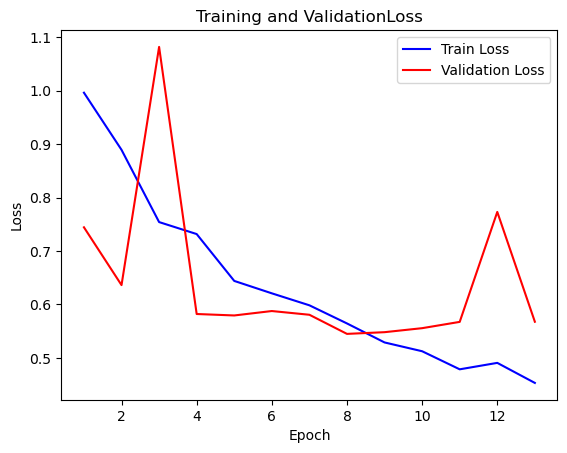

Figure Training and ValidationAccuracy saved!


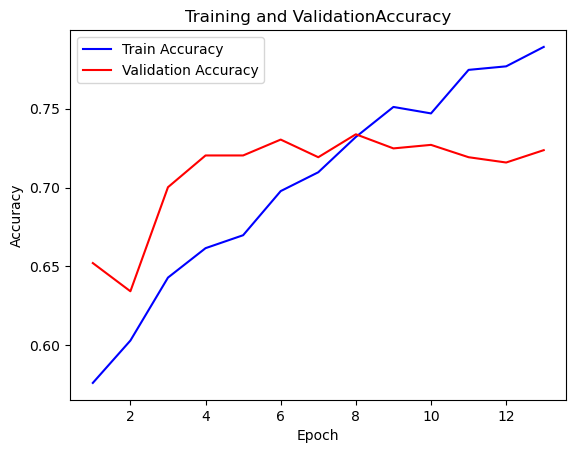

In [7]:
# Save the training results of meta_model
from src.utils import safe_save_training_results

best_val_acc = max(history.history['val_accuracy'])
model_save_dir = 'baseline_models/Ranking_VGG19_BestValAcc{:.4f}_{}'.format(best_val_acc,dataset_seed)

safe_save_training_results(hyperparams_dict={'model_architecture': hp_model_architecture,
                                             'model_training': hps_model_training,
                                             'data_preprocessing': hps_data_preprocessing},
                           model=meta_model,
                           model_save_type='keras', 
                           history=history, 
                           his_save_type='csv', 
                           save_dir = model_save_dir,)

# Save the plot
plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)